In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,TimeDistributed, MaxPool2D,Flatten,Reshape,GlobalAveragePooling2D, Conv2D,Conv3D ,MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU, LSTM
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import sklearn
import os
import sys
import numpy as np
import shutil
from PIL import Image
import pickle
from tensorflow.keras.models import save_model 

import random

2024-05-13 21:52:32.197676: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 21:52:32.235860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd

video_names=[]
labels=[]

p = 'data1/fake'
for i in os.listdir(p) :
    p1 = os.path.join(p,i)
    video_names.append(p1)
    labels.append('FAKE')
    
p = 'data1/real'
for i in os.listdir(p) :
    p1 = os.path.join(p,i)
    video_names.append(p1)
    labels.append('REAL')
# Save DataFrame to CSV
data = {"video_name": video_names, "label": labels}
df = pd.DataFrame(data)
df.to_csv("video_labels.csv", index=False)

In [50]:
import tensorflow as tf
import glob
import cv2
import numpy as np

# Define image size and normalization parameters
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Function to load and preprocess video frames
def process_video(video_path):
    frames = []
    vidObj = cv2.VideoCapture(video_path)
    success = 1
    while success:
        success, image = vidObj.read()
        if success:
            # Resize image to desired size
            image = cv2.resize(image, (im_size, im_size))
            # Convert from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Normalize image
            image = (image / 255.0 - mean) / std
            frames.append(image)
    return frames

# Function to create dataset
def create_dataset(video_files):
    for video_file in video_files:
        # Process video frames
        frames = process_video(video_file)
        # Yield frames and label (0 or 1 depending on directory)
        if 'fake' in video_file.lower():
            label = 0
        else:
            label = 1
        yield frames, label

# Get list of video files
video_fil  = glob.glob('data1/fake/*.mp4')
video_fil = video_fil[:1000]
video_fil1  = glob.glob('data1/real/*.mp4')
video_fil1 = video_fil1[:1000]
video_fil = video_fil+ video_fil1
print(video_fil)
# Create TensorFlow dataset
tf_dataset = tf.data.Dataset.from_generator(create_dataset, args=[video_fil], output_signature=(tf.TensorSpec(shape=(None, im_size, im_size, 3), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32)))

# Shuffle and batch the dataset
tf_dataset = tf_dataset.shuffle(buffer_size=1000).batch(batch_size=32)

# Print number of batches in the dataset
num_batches = tf.data.experimental.cardinality(tf_dataset).numpy()
print("Number of batches in the dataset:", num_batches)


['data1/fake/id35_id23_0006.mp4', 'data1/fake/id6_id4_0005.mp4', 'data1/fake/id38_id35_0002.mp4', 'data1/fake/id3_id9_0005.mp4', 'data1/fake/id43_id47_0009.mp4', 'data1/fake/id21_id26_0002.mp4', 'data1/fake/id53_id49_0003.mp4', 'data1/fake/id45_id41_0004.mp4', 'data1/fake/id38_id34_0003.mp4', 'data1/fake/id17_id1_0004.mp4', 'data1/fake/id52_id57_0005.mp4', 'data1/fake/id31_id17_0009.mp4', 'data1/fake/id17_id9_0005.mp4', 'data1/fake/id23_id3_0002.mp4', 'data1/fake/id27_id25_0004.mp4', 'data1/fake/id57_id55_0007.mp4', 'data1/fake/id20_id1_0002.mp4', 'data1/fake/id11_id7_0008.mp4', 'data1/fake/id21_id30_0004.mp4', 'data1/fake/id9_id3_0006.mp4', 'data1/fake/id45_id48_0000.mp4', 'data1/fake/id29_id31_0000.mp4', 'data1/fake/id30_id16_0009.mp4', 'data1/fake/id45_id43_0008.mp4', 'data1/fake/id2_id37_0009.mp4', 'data1/fake/id20_id16_0005.mp4', 'data1/fake/id0_id16_0000.mp4', 'data1/fake/id37_id2_0006.mp4', 'data1/fake/id38_id37_0005.mp4', 'data1/fake/id1_id6_0006.mp4', 'data1/fake/id16_id9_0012

In [51]:
#to load preprocessod video to memory
import json
import glob
import numpy as np
import cv2
import copy
import random
video_fil  = glob.glob('data1/fake/*.mp4')
video_fil = video_fil[:1000]
video_fil1  = glob.glob('data1/real/*.mp4')
video_fil1 = video_fil1[:1000]
video_fil = video_fil+ video_fil1
random.shuffle(video_fil)
random.shuffle(video_fil)
frame_count = []
for video_file in video_fil:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_fil.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [466, 517, 378, 335, 446, 306, 295, 307, 446, 317, 310, 332, 474, 461, 314, 317, 366, 228, 316, 503, 475, 563, 349, 585, 442, 516, 451, 398, 398, 345, 324, 298, 465, 364, 555, 323, 302, 214, 350, 507, 313, 492, 305, 458, 397, 375, 317, 328, 458, 262, 508, 465, 311, 487, 333, 307, 376, 516, 462, 432, 311, 314, 456, 466, 467, 381, 334, 485, 280, 322, 165, 297, 479, 472, 321, 404, 314, 383, 479, 380, 303, 359, 298, 322, 311, 312, 464, 315, 199, 350, 270, 353, 639, 473, 471, 303, 350, 319, 319, 506, 365, 317, 478, 485, 477, 480, 457, 165, 473, 513, 318, 483, 303, 475, 305, 497, 441, 400, 307, 530, 451, 369, 317, 342, 315, 186, 460, 462, 301, 305, 347, 485, 318, 324, 534, 481, 310, 468, 380, 321, 350, 476, 326, 470, 301, 454, 316, 476, 470, 338, 313, 611, 337, 310, 470, 469, 332, 492, 480, 447, 338, 501, 474, 420, 209, 314, 332, 322, 571, 353, 342, 447, 491, 352, 526, 462, 334, 364, 310, 272, 363, 314, 485, 485, 318, 461, 295, 477, 459, 311, 448, 314, 475, 322, 321, 317, 321, 30

In [52]:
# load the video name and labels from csv
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["video_name"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()
     

In [53]:
def number_of_real_and_fake_videos(data_list):
    header_list = ["video_name","label"]
    lab = pd.read_csv('video_labels.csv', names=header_list)
    fake = 0
    real = 0
    for video_file in data_list:
        temp_video = video_file
        match = labels.loc[labels["video_name"] == temp_video]
        # print(match)
        if not match.empty:
            label = match.iloc[0, 1]
            
            if label == 'FAKE':
                fake += 1
            elif label == 'REAL':
                real += 1
    return real, fake


train :  1511
test :  378
TRAIN:  Real: 712  Fake: 799
TEST:  Real: 177  Fake: 201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


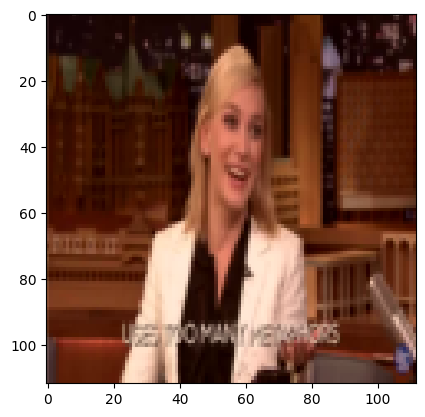

In [54]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms

header_list = ["video_name","label"]
labels = pd.read_csv('video_labels.csv',names=header_list)
#print(labels)
train_videos = video_fil[:int(0.8*len(video_fil))]
valid_videos = video_fil[int(0.8*len(video_fil)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)

#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 0)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 0)
image,label = train_data[0]
im_plot(image[0,:,:,:])

In [55]:
for inputs, targets in valid_loader:
    print("Batch Inputs:", inputs)
    print("Batch Targets:", targets)


Batch Inputs: tensor([[[[[ 0.5022,  0.4166,  0.2967,  ...,  1.3413,  1.3413,  1.3413],
           [ 0.6221,  0.3481,  0.2453,  ...,  1.3413,  1.3413,  1.3413],
           [ 0.6392,  0.3309,  0.2111,  ...,  1.3584,  1.3584,  1.3413],
           ...,
           [ 2.0948,  2.1119,  2.1119,  ..., -0.1143, -0.0801, -0.1143],
           [ 2.0948,  2.0948,  2.1119,  ..., -0.0972, -0.1143, -0.1143],
           [ 2.0948,  2.0948,  2.1119,  ..., -0.0972, -0.1143, -0.1143]],

          [[ 0.4503, -0.1099, -0.4076,  ...,  1.5532,  1.5532,  1.5532],
           [ 0.6954, -0.0749, -0.4251,  ...,  1.5532,  1.5532,  1.5532],
           [ 0.7304, -0.0749, -0.4601,  ...,  1.5707,  1.5707,  1.5532],
           ...,
           [ 1.7283,  1.7458,  1.7458,  ...,  0.9580,  0.9405,  0.9055],
           [ 1.7283,  1.7283,  1.7458,  ...,  0.9405,  0.9055,  0.9055],
           [ 1.7283,  1.7283,  1.7458,  ...,  0.9405,  0.9055,  0.9055]],

          [[ 1.0539,  0.7402,  0.4962,  ...,  1.9603,  1.9603,  1.9603],
 

In [56]:
from torchvision.models import resnext50_32x4d

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        
        # Initialize a ResNeXt model
        resnext_model = resnext50_32x4d(pretrained=False)
        
        # Load the state dictionary of the manually downloaded ResNeXt model
        resnext_weights_path = "resnext50_32x4d-7cdf4587.pth"
        resnext_state_dict = torch.load(resnext_weights_path)
        
        # Load the state dictionary into the initialized ResNeXt model
        resnext_model.load_state_dict(resnext_state_dict)
        
        # Modify the model according to your requirements
        self.model = nn.Sequential(*list(resnext_model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        return fmap, self.dp(self.linear1(torch.mean(x_lstm, dim=1)))

In [57]:
model = Model(2)
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.FloatTensor))


/home/shivanandg/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shivanandg/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [58]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.LongTensor)
            inputs = inputs
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'content/checkpoint.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.type(torch.cuda.FloatTensor)
                inputs = inputs
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size
     

In [59]:
lr = 1e-5#0.001
#number of epochs 
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

[Epoch 1/20] [Batch 377 / 378] [Loss: 0.704002, Acc: 51.62%]Testing
[Batch 94 / 95]  [Loss: 0.673108, Acc: 59.79%]
Accuracy 59.78835978835979
[Epoch 2/20] [Batch 377 / 378] [Loss: 0.663923, Acc: 59.36%]Testing
[Batch 94 / 95]  [Loss: 0.662008, Acc: 61.90%]
Accuracy 61.904761904761905
[Epoch 3/20] [Batch 377 / 378] [Loss: 0.642708, Acc: 64.00%]Testing
[Batch 94 / 95]  [Loss: 0.645361, Acc: 62.43%]
Accuracy 62.43386243386244
[Epoch 4/20] [Batch 377 / 378] [Loss: 0.610525, Acc: 67.04%]Testing
[Batch 94 / 95]  [Loss: 0.661063, Acc: 63.23%]
Accuracy 63.22751322751323
[Epoch 5/20] [Batch 377 / 378] [Loss: 0.572731, Acc: 71.14%]Testing
[Batch 94 / 95]  [Loss: 0.686391, Acc: 62.96%]
Accuracy 62.96296296296296
[Epoch 6/20] [Batch 377 / 378] [Loss: 0.569121, Acc: 71.01%]Testing
[Batch 94 / 95]  [Loss: 0.664716, Acc: 62.96%]
Accuracy 62.96296296296296
[Epoch 7/20] [Batch 377 / 378] [Loss: 0.563677, Acc: 71.14%]Testing
[Batch 94 / 95]  [Loss: 0.681962, Acc: 62.96%]
Accuracy 62.96296296296296
[Epoc